In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import random as rd
from sklearn import neighbors
import sklearn
import time
from sklearn.cluster import KMeans


In [2]:
mat = scipy.io.loadmat('mnist-original.mat') 
data = np.transpose(mat['data'])
label = np.transpose(mat['label'])
X = [data[i].reshape(784,1) for i in range(len(data))] # on créé une nouvelle liste qui va contenir nos matrices 28x28
X_beta = [data[i].reshape(28,28) for i in range(len(data)) ]
k=20 # nombre de cluster utilisé
m=70000 # nombre de données utilisées
n=784  
tol=10**(-3)

In [3]:
def index_chiffre(n, y):  # elle nous renvoie un tableau contenant les indices représentants le chiffre n
    return [i for i in range(len(y)) if y[i]==n] 

def image_moyenne(n, X, y): # cette fonction renvoie la matrice moyenne (centroïde) pour le chiffre n
    index = index_chiffre(n, y) 
    sum_matrice = np.zeros((28,28)) # la matrice qui sera utilisée dans la somme
    for i in index:
        sum_matrice += X[i] # on somme toutes les matrices représentants le chiffre n
    return sum_matrice/len(index)

centroide_total = []
for i in range(10): # on calcul le centroïde pour chaque chiffre i entre 0 et 9 avec X et label 
    centroide_total.append(image_moyenne(i, X_beta,label))
centroide_total=[centroide_total[i].reshape(784,1) for i in range(len(centroide_total))]

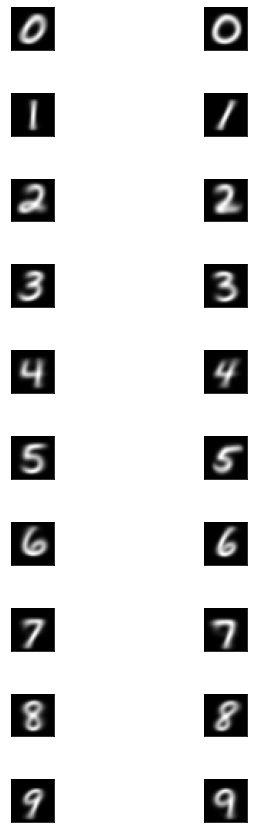

In [4]:
chiffres = range(10)
nb_clusters = 2
centre=[]

fig, ax = plt.subplots(len(chiffres),nb_clusters,figsize=(15,15))
for i in ax.flat:
        i.set(xticks=[], yticks=[])

for j,t in zip(range(len(chiffres)),chiffres):
    idx = np.where((label == t))[0]
    Xk = np.array(data)[idx]    
    Ykk = np.array(label)[idx]
    Yk = np.reshape(Ykk, (len(Ykk),))
    kmeans = sklearn.cluster.KMeans(n_clusters=nb_clusters).fit(Xk,Yk)
    centroidk = kmeans.cluster_centers_
    for i in range(nb_clusters):
        ax[j, i].imshow(np.reshape(centroidk[i], (28,28)),cmap='gray')
        centre.append(centroidk[i])
fig.subplots_adjust(hspace=1.0, wspace=-0.7)
plt.show()

In [5]:
centerr = [centre[i].reshape(784,1) for i in range(len(centre))]

In [6]:
# on initialise les centroides aléatoirement et on associe les données correspondant 
clusters = {}
for i in range(k):
    clusters[i] = [] 
    
centroids= {}
for i in range(k):
    if i< len(centerr):
        centroids[i]=centerr[i]
    else:
        rand=rd.randint(0,m-1)
        centroids[i] = X[rand]
    

    




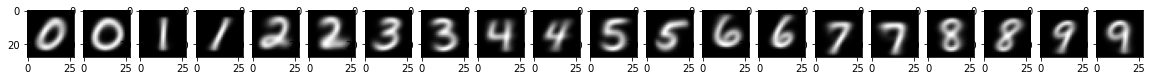

In [7]:
fig, ax = plt.subplots(1,k,figsize=(20,2)) # affichage des centroïdes 
for i in range(k):
    ax[i].imshow(centroids[i].reshape(28,28),cmap='gray')

indice=[[] for i in range(k)]
for i in range(m):
    euc_dist = [np.linalg.norm(X[i] - centroids[j]) for j in range(k)]
    minn=np.argmin(np.asarray(euc_dist))
    clusters[minn].append(X[i])
    indice[minn].append(i)

In [8]:
def re_clusters(X, centroids, k):# fonction qui recalcule les clusters
    clusters = {}
    indice=[[] for i in range(k)]
    for i in range(k):
        clusters[i] = []
    for i in range(m):
        euc_dist = [np.linalg.norm(X[i] - centroids[j]) for j in range(k)]
        clusters[np.argmin(np.asarray(euc_dist))].append(X[i])
        indice[np.argmin(np.asarray(euc_dist))].append(i)
    return [clusters,indice]

def re_centroids(clusters, k):# fonction qui recalcule les centroids
    centroids= {}
    for i in range(k):
        centroids[i] = np.mean(clusters[i], axis=0)
        
    return centroids

def coherence(centroids_j, clusters_j):
    temp=[np.linalg.norm(data - centroids_j)**2 for data in clusters_j ]
    return sum(temp)

def quality(centroids, clusters):
    temp=[coherence(centroids[i],clusters[i]) for i in range(k)]
    return sum(temp)


In [9]:
clusters_nv=re_clusters(X, centroids, k)[0]
centroids_nv=re_centroids(clusters, k)
L=[]
start=time.time()
while abs(quality(centroids, clusters)-quality(centroids_nv, clusters_nv))>tol :
    L.append(abs(quality(centroids, clusters)-quality(centroids_nv, clusters_nv)))
    centroids=centroids_nv
    clusters=clusters_nv
    clusters_nv=re_clusters(X, centroids, k)[0]
    indice=re_clusters(X, centroids, k)[1]
    centroids_nv=re_centroids(clusters_nv, k)
end=time.time()

95
Temps de réalisation : 2514.645168066025 secondes


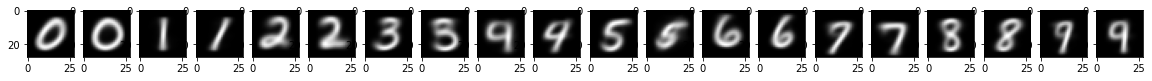

In [10]:
L.append(abs(quality(centroids, clusters)-quality(centroids_nv, clusters_nv)))
print(len(L))
print("Temps de réalisation : " + str(end-start) + " secondes")
fig, ax = plt.subplots(1,k,figsize=(20,2)) # affichage des centroïdes 
for i in range(k):
    ax[i].imshow(centroids[i].reshape(28,28),cmap='gray')

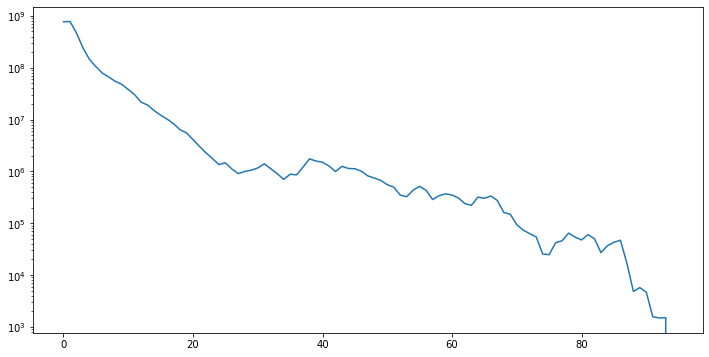

In [11]:
plt.figure(figsize=(12,6)) 
plt.plot([i for i in range(len(L))],L)
plt.yscale('log')
plt.show()

In [12]:
#compter le nb d'éléments : x = chaque chiffre et labels = liste des labels 
def nb_occurences(x,labels):
    n=0
    for i in labels:
        if x==i:
            n=n+1
    return n

#Label majoritaire dans chaque cluster 
def majoritaire(l):
    xmaj=l[0]
    nbmaj=nb_occurences(xmaj,l)
    for i in range(1,len(l)):
        if nb_occurences(l[i],l)>nbmaj:
            xmaj=l[i]
            nbmaj=nb_occurences(l[i],l)
    return xmaj



In [13]:
#Liste des labels représentés dans chaque classe 
start=time.time()
labels_clusters = [[] for _ in range(k)]
for i in range(len(indice)):
    for j in indice[i]:
        labels_clusters[i].append(label[j])
end=time.time()
print('Temps de réalisation : '+str(end-start)+' secondes.')

Temps de réalisation : 0.024109840393066406 secondes.


In [14]:
classes = []       #liste des chiffres majoritaires pour chaque cluster  
start=time.time()
for i in range(k):
    classes.append(majoritaire(labels_clusters[i]))
end=time.time()
print('Temps de réalisation : '+str(end-start)+' secondes.')

Temps de réalisation : 118.74246025085449 secondes.


[array([0.]), array([0.]), array([1.]), array([1.]), array([2.]), array([2.]), array([3.]), array([3.]), array([4.]), array([4.]), array([5.]), array([5.]), array([6.]), array([6.]), array([7.]), array([7.]), array([8.]), array([8.]), array([9.]), array([9.])]


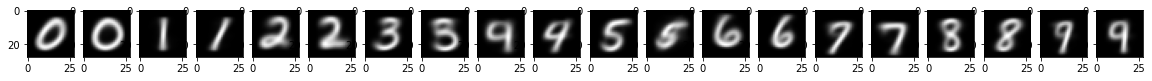

In [15]:
#Je les remontre pour voir si ça correspond bien. 

fig, ax = plt.subplots(1,k,figsize=(20,2)) # affichage des centroïdes 
for i in range(k):
    ax[i].imshow(centroids[i].reshape(28,28),cmap='gray')
print(classes)

In [16]:
#calcul précision : 

def calcul_pourcentage(cl):# renvoie le pourcentage de réussite 
    precision = []
    for _ in range(len(cl)):
        A =[i for i in labels_clusters[_] if i==cl[_]]
        precision.append(len(A)*100/len(labels_clusters[_]))
    #print(precision)    --> donne la précision de chaque centroïde
    print('La précision globale est de '+str(np.mean(precision))+'%.')

In [17]:
calcul_pourcentage(classes)

La précision globale est de 73.70879221012753%.
